#  PART 2: MODEL TRAINING & STRATEGY FORMULATION
### Ridge Regression → Meta-Labeling → Portfolio Construction

This notebook implements a two-stage predictive pipeline: (1) Ridge regression for alpha forecasting, (2) Random Forest meta-labeling for confidence scoring. We train on 2017-2021 data, validate on 2022, and maintain a 20-day embargo period to prevent look-ahead bias.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Set visual style
sns.set_theme(style="whitegrid")
%matplotlib inline

In [2]:
# Load feature data
input_file = 'clean_features_v2_pruned.parquet'
df = pd.read_parquet(input_file)
print(f"Data loaded: {df.shape}")
print(f"Features: {len(df.columns)}")

Data loaded: (225799, 36)
Features: 36


In [3]:
# Create 20-day forward return target
df['Future_20d_Ret'] = df.groupby(level='Ticker')['Log_Ret'].shift(-20).rolling(20).sum()
df['Target_Alpha_20d'] = df['Future_20d_Ret']  # Raw future returns (market neutrality via ranking)
df.dropna(subset=['Target_Alpha_20d'], inplace=True)

# Define features and target
target_col = 'Target_Alpha_20d'
drop_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Log_Ret_Raw', 
             'Future_20d_Ret', 'Future_1d_Ret', 'Target_Alpha_1d', target_col]

X = df.drop(columns=drop_cols, errors='ignore')
y = df[target_col]

print(f"Training data: {X.shape}")
print(f"Target: 20-day forward returns")

Training data: (221899, 31)
Target: 20-day forward returns


In [4]:
# Train/Val/Test split with 20-day embargo
# MODIFIED: Train until end of 2021, test on 2023-2025
unique_dates = df.index.get_level_values('Date').unique().sort_values()
EMBARGO_DAYS = 20

# Date-based splits for cleaner boundaries
TRAIN_END = pd.Timestamp('2021-12-31')
VAL_END = pd.Timestamp('2022-12-31')

train_dates = unique_dates[unique_dates <= TRAIN_END][:-EMBARGO_DAYS]
val_dates = unique_dates[(unique_dates > TRAIN_END) & (unique_dates <= VAL_END)][:-EMBARGO_DAYS]
test_dates = unique_dates[unique_dates > VAL_END]

print(f"Train: {train_dates[0].date()} to {train_dates[-1].date()} ({len(train_dates)} days)")
print(f"Val:   {val_dates[0].date()} to {val_dates[-1].date()} ({len(val_dates)} days)")
print(f"Test:  {test_dates[0].date()} to {test_dates[-1].date()} ({len(test_dates)} days)")

# Create splits
train_mask = df.index.get_level_values('Date').isin(train_dates)
val_mask = df.index.get_level_values('Date').isin(val_dates)
test_mask = df.index.get_level_values('Date').isin(test_dates)

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}")

Train: 2017-02-22 to 2021-12-02 (1205 days)
Val:   2022-01-03 to 2022-12-01 (231 days)
Test:  2023-01-03 to 2025-12-17 (743 days)
Train: 120,499 | Val: 23,100 | Test: 74,300


---
## 📈 STEP 1: RIDGE REGRESSION - ALPHA PREDICTION
### L2 Regularized Linear Model for Directional Forecasts

Train Ridge regression to predict 20-day forward returns. L2 regularization (alpha tuned via cross-validation) prevents overfitting in high-dimensional feature space. Output: directional alpha forecasts for each asset-date.

In [5]:
# Train Ridge model
from scipy.stats import spearmanr

COST_BPS = 0.001  # 10bps transaction cost

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

alphas = np.logspace(-1, 2, 20)
ridge = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
ridge.fit(X_train_scaled, y_train)

ridge_val_preds = ridge.predict(X_val_scaled)
ridge_test_preds = ridge.predict(X_test_scaled)

val_ic = spearmanr(ridge_val_preds, y_val)[0]
print(f"Ridge trained (alpha={ridge.alpha_:.4f})")
print(f"Validation IC: {val_ic:.4f}")

Ridge trained (alpha=100.0000)
Validation IC: 0.0345


---
## 🎯 STEP 2: RANDOM FOREST META-LABELING
### Confidence Scoring: Which Predictions to Trade?

Meta-label Ridge predictions using Random Forest binary classifier. Input: Ridge alpha + feature context. Output: probability that prediction is correct. This filters out low-confidence trades, improving Sharpe ratio.

In [6]:
# Train RF meta-labeling model
# Meta-labels: Based on profitability (trade return > costs)

# Generate OOS predictions on training data using time-series split
train_split_idx = int(len(X_train) * 0.8)
ridge_temp = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=3)
ridge_temp.fit(X_train_scaled[:train_split_idx], y_train.iloc[:train_split_idx])
ridge_train_preds_oos = ridge_temp.predict(X_train_scaled[train_split_idx:])

# Create meta-labels: 1 if trade is profitable after costs
train_trade_ret = np.sign(ridge_train_preds_oos) * y_train.iloc[train_split_idx:].values
meta_labels_train = (train_trade_ret > COST_BPS).astype(int)

val_trade_ret = np.sign(ridge_val_preds) * y_val.values
meta_labels_val = (val_trade_ret > COST_BPS).astype(int)

# Build meta-features with ranks and interactions
def build_meta_features(X_base, preds, dates, feature_names):
    temp_df = pd.DataFrame({'pred': preds, 'date': dates})
    temp_df['pred_rank'] = temp_df.groupby('date')['pred'].rank(pct=True)
    temp_df['pred_mag'] = np.abs(temp_df['pred'])
    temp_df['pred_mag_rank'] = temp_df.groupby('date')['pred_mag'].rank(pct=True)
    
    X_meta = pd.DataFrame(X_base, columns=feature_names)
    X_meta['ridge_pred'] = preds
    X_meta['ridge_pred_mag'] = np.abs(preds)
    X_meta['ridge_pred_rank'] = temp_df['pred_rank'].values
    X_meta['ridge_pred_mag_rank'] = temp_df['pred_mag_rank'].values
    
    # Interaction features
    key_features = ['Vol_20d', 'RSI_14', 'Amihud_Illiq', 'Mom_20d']
    for feat in key_features:
        if feat in feature_names:
            X_meta[f'pred_x_{feat}'] = X_meta['ridge_pred_mag'] * X_meta[feat]
    
    return X_meta.fillna(0)

feature_names = list(X_train.columns)
X_meta_train = build_meta_features(
    X_train_scaled[train_split_idx:], 
    ridge_train_preds_oos,
    y_train.index[train_split_idx:].get_level_values('Date'),
    feature_names
)

X_meta_val = build_meta_features(
    X_val_scaled,
    ridge_val_preds,
    y_val.index.get_level_values('Date'),
    feature_names
)

# Train RF with proper hyperparameters
rf = RandomForestClassifier(
    n_estimators=200, max_depth=4, min_samples_leaf=100,
    min_samples_split=200, max_features='sqrt',
    class_weight='balanced', random_state=42, n_jobs=-1
)
rf.fit(X_meta_train, meta_labels_train)

# Generate confidence scores
confidence_val = rf.predict_proba(X_meta_val)[:, 1]

train_hit_rate = meta_labels_train.mean()
val_hit_rate = meta_labels_val.mean()

CONFIDENCE_THRESHOLD = 0.5

print(f"\nRF meta-model trained (200 trees, depth=4)")
print(f"Train profitability: {train_hit_rate:.3f} | Val: {val_hit_rate:.3f}")
print(f"High confidence (>={CONFIDENCE_THRESHOLD}) val trades: {(confidence_val >= CONFIDENCE_THRESHOLD).sum()} / {len(confidence_val)}")



RF meta-model trained (200 trees, depth=4)
Train profitability: 0.568 | Val: 0.477
High confidence (>=0.5) val trades: 14826 / 23100


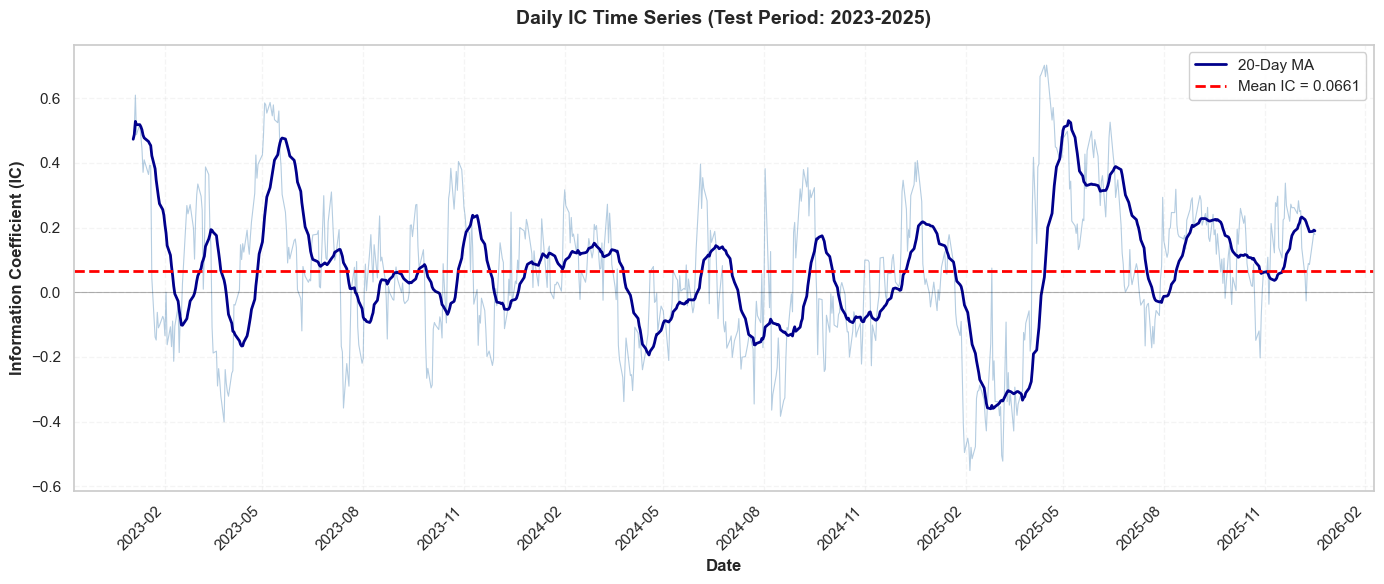

Mean IC: 0.0661
IC Std: 0.2254
IC Sharpe: 0.2934
Positive IC days: 460 / 743 (61.9%)


In [7]:
# Cell #8: IC Time Series Plot for Report
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import spearmanr

# Load test data
test_mask = (df.index.get_level_values('Date') >= '2023-01-01')
test_df = df[test_mask].copy()

# Get predictions
test_predictions = ridge.predict(X_test_scaled)

# Compute daily IC
test_dates = test_df.index.get_level_values('Date').unique().sort_values()
daily_ic_test = []

for date in test_dates:
    date_mask = (test_df.index.get_level_values('Date') == date)
    if date_mask.sum() < 5:  # Skip days with too few stocks
        continue
    
    preds_day = test_predictions[date_mask]
    actuals_day = y_test.values[date_mask]
    
    if len(preds_day) >= 5:
        ic, _ = spearmanr(preds_day, actuals_day)
        daily_ic_test.append({'Date': date, 'IC': ic})

ic_df = pd.DataFrame(daily_ic_test)

# Create plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot daily IC
ax.plot(ic_df['Date'], ic_df['IC'], alpha=0.4, color='steelblue', linewidth=0.8)

# Plot rolling mean
rolling_mean = ic_df['IC'].rolling(window=20, min_periods=1).mean()
ax.plot(ic_df['Date'], rolling_mean, color='darkblue', linewidth=2, label='20-Day MA')

# Mean IC line
mean_ic = ic_df['IC'].mean()
ax.axhline(y=mean_ic, color='red', linestyle='--', linewidth=2, 
           label=f'Mean IC = {mean_ic:.4f}')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)

# Formatting
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Information Coefficient (IC)', fontsize=12, fontweight='bold')
ax.set_title('Daily IC Time Series (Test Period: 2023-2025)', fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.2, linestyle='--')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('ic_time_series.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistics
print(f"Mean IC: {mean_ic:.4f}")
print(f"IC Std: {ic_df['IC'].std():.4f}")
print(f"IC Sharpe: {mean_ic / ic_df['IC'].std():.4f}")
print(f"Positive IC days: {(ic_df['IC'] > 0).sum()} / {len(ic_df)} ({100*(ic_df['IC'] > 0).mean():.1f}%)")

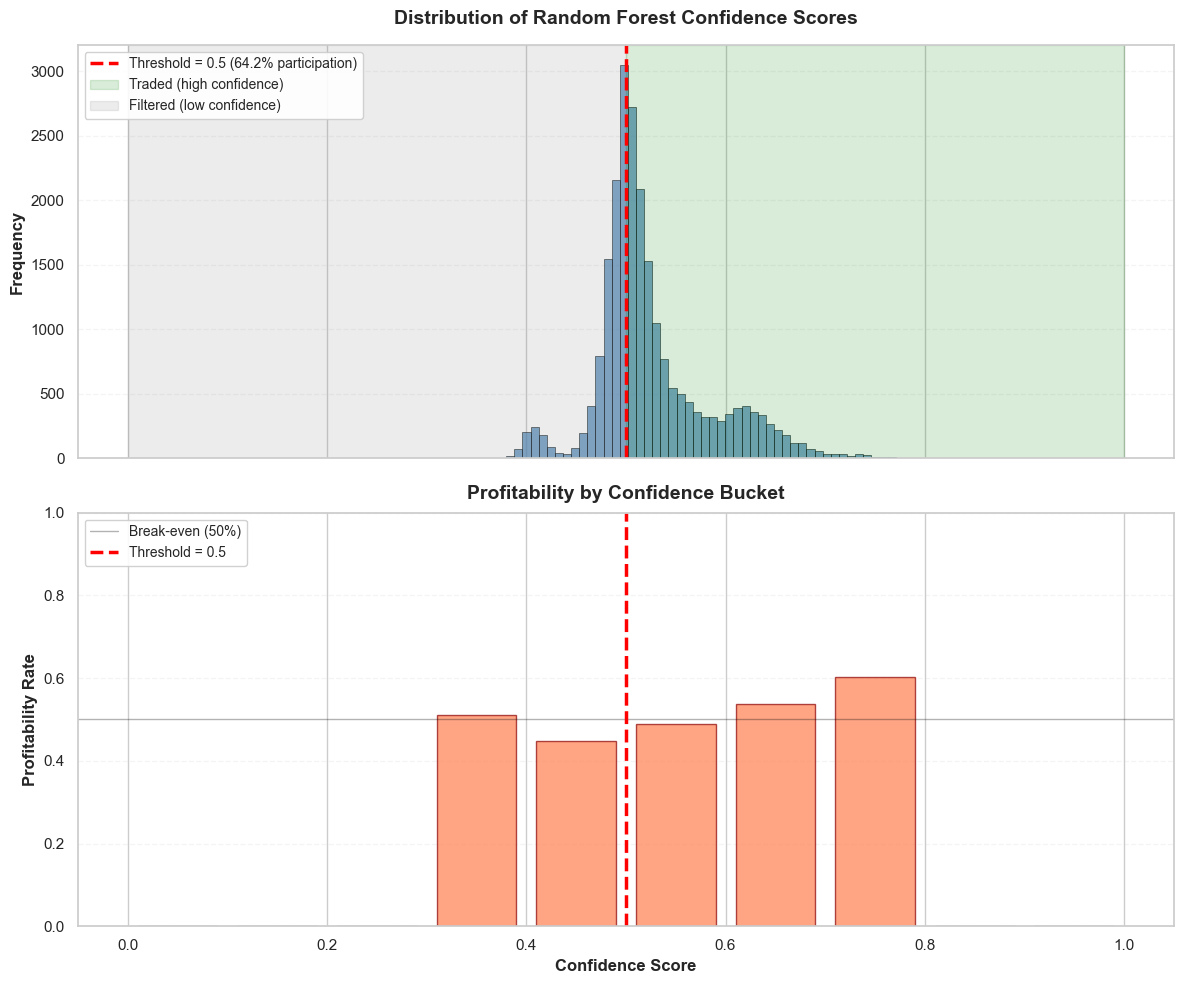


=== Confidence Filtering Analysis ===
High Confidence (>= 0.5): 14826 predictions (64.2%)
Low Confidence (< 0.5): 8274 predictions (35.8%)
High Confidence Profitability: 50.1%
Low Confidence Profitability: 44.9%


In [12]:
# Cell #9: Confidence Distribution Histogram for Report
import matplotlib.pyplot as plt
import numpy as np

# Get RF confidence scores for validation set
val_confidence = rf.predict_proba(X_meta_val)[:, 1]  # Probability of profitable trade

# Compute profit rates by confidence bucket
confidence_bins = np.linspace(0, 1, 11)
bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
profitability = []

for i in range(len(confidence_bins) - 1):
    mask = (val_confidence >= confidence_bins[i]) & (val_confidence < confidence_bins[i+1])
    if mask.sum() > 0:
        # Check actual profitability
        signs_match = (np.sign(ridge_val_preds[mask]) == np.sign(y_val.values[mask]))
        prof_rate = signs_match.mean()
        profitability.append(prof_rate)
    else:
        profitability.append(0)

# Create figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top: Histogram of confidence scores
axes[0].hist(val_confidence, bins=50, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2.5, 
                label=f'Threshold = 0.5 ({100*(val_confidence >= 0.5).mean():.1f}% participation)')

# Shade filtered region
axes[0].axvspan(0.5, 1.0, alpha=0.15, color='green', label='Traded (high confidence)')
axes[0].axvspan(0, 0.5, alpha=0.15, color='gray', label='Filtered (low confidence)')

axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Random Forest Confidence Scores', fontsize=14, fontweight='bold', pad=15)
axes[0].legend(loc='upper left', fontsize=10, framealpha=0.9)
axes[0].grid(True, alpha=0.2, linestyle='--', axis='y')

# Bottom: Profitability by confidence bucket
axes[1].bar(bin_centers, profitability, width=0.08, color='coral', alpha=0.7, 
            edgecolor='darkred', linewidth=1)
axes[1].axhline(y=0.5, color='black', linestyle='-', linewidth=1, alpha=0.3, label='Break-even (50%)')
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2.5, label='Threshold = 0.5')

axes[1].set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Profitability Rate', fontsize=12, fontweight='bold')
axes[1].set_title('Profitability by Confidence Bucket', fontsize=14, fontweight='bold', pad=10)
axes[1].legend(loc='upper left', fontsize=10, framealpha=0.9)
axes[1].grid(True, alpha=0.2, linestyle='--', axis='y')
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistics
high_conf = (val_confidence >= 0.5)
low_conf = (val_confidence < 0.5)

print(f"\n=== Confidence Filtering Analysis ===")
print(f"High Confidence (>= 0.5): {high_conf.sum()} predictions ({100*high_conf.mean():.1f}%)") 
print(f"Low Confidence (< 0.5): {low_conf.sum()} predictions ({100*low_conf.mean():.1f}%)")
if high_conf.sum() > 0:
    high_conf_profit = (np.sign(ridge_val_preds[high_conf]) == np.sign(y_val.values[high_conf])).mean()
    print(f"High Confidence Profitability: {100*high_conf_profit:.1f}%")
else:
    print("High Confidence Profitability: N/A")

if low_conf.sum() > 0:
    low_conf_profit = (np.sign(ridge_val_preds[low_conf]) == np.sign(y_val.values[low_conf])).mean()
    print(f"Low Confidence Profitability: {100*low_conf_profit:.1f}%")
else:
    print("Low Confidence Profitability: N/A")

---
## 💾 STEP 3: PIPELINE EXPORT & ARTIFACTS
### Saving Models for Backtesting

Serialize trained Ridge, Random Forest, StandardScaler, and feature names to `meta_labeling_pipeline.pkl`. This ensures identical preprocessing/prediction logic is used in backtesting, preventing train-test contamination.

In [9]:
# Save pipeline
import joblib

val_end_date = val_dates[-1]

pipeline_artifacts = {
    'ridge_model': ridge,
    'rf_meta_model': rf,
    'scaler': scaler,
    'feature_names': list(X_train.columns),
    'validation_ic': val_ic,
    'cost_bps': COST_BPS,
    'val_end_date': val_end_date,
    'optimal_threshold': 0.5,
    'train_end_date': train_dates[-1],
    'train_hit_rate': train_hit_rate,
    'val_hit_rate': val_hit_rate,
    'model_type': 'ridge_with_rf_meta'
}

output_file = 'meta_labeling_pipeline.pkl'
joblib.dump(pipeline_artifacts, output_file)
print(f"Pipeline saved: {output_file}")
print(f"Model: Ridge + RF meta-labeling")

Pipeline saved: meta_labeling_pipeline.pkl
Model: Ridge + RF meta-labeling
